# Dual Doppler Analysis

In [1]:
import pyart
import pydda
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# read in the CSU sounding for this case
import xarray as xr
ds = xr.open_dataset('../../Downloads/CSU_griddedsounding.nc')

In [3]:
ds.sel(launch_time='2018-11-10').launch_time.values

array(['2018-11-10T22:09:00.000000000', '2018-11-10T21:04:00.000000000',
       '2018-11-10T20:01:00.000000000', '2018-11-10T20:00:00.000000000',
       '2018-11-10T18:06:00.000000000', '2018-11-10T17:04:00.000000000',
       '2018-11-10T16:02:00.000000000', '2018-11-10T15:00:00.000000000'],
      dtype='datetime64[ns]')

In [4]:
sounding_ds = ds.sel(launch_time = ds.sel(launch_time='2018-11-10').launch_time.values[4]).dropna('pressure')

In [5]:
uwnd = sounding_ds.Ucmp.values
vwnd = sounding_ds.Vcmp.values
alt = sounding_ds.Alt.values

In [6]:
profile = pyart.core.HorizontalWindProfile.from_u_and_v(alt, uwnd, vwnd)

In [7]:
def plot_radars(radar):
    display = pyart.graph.RadarDisplay(radar)

    fig = plt.figure(figsize=(20, 20))

    nyq = radar.instrument_parameters['nyquist_velocity']['data'][0]

    # Reflectivity
    ax = fig.add_subplot(221)
    display.plot('DBZHC_F', 1, vmin=-32, vmax=64., cmap='pyart_HomeyerRainbow')
    display.plot_range_rings([10, 20, 30, 40])
    display.plot_cross_hair(5.)
    display.set_limits((-40, 40), (-40, 40), ax=ax)

    # Radial Velocity
    ax = fig.add_subplot(222)
    display.plot('VEL_F', 1, ax=ax, cmap = 'pyart_balance')
    display.plot_range_rings([10, 20, 30, 40])
    display.set_limits((-40, 40), (-40, 40), ax=ax)

    #display.set_limits((-300, 300), (-300, 300), ax=ax)

    # Corrected Reflectivity - Karen
    ax = fig.add_subplot(223)
    display.plot('ZM', 1, vmin=-32, vmax=64., ax=ax, cmap = 'pyart_HomeyerRainbow')
    display.plot_range_rings([10, 20, 30, 40])
    display.set_limits((-40, 40), (-40, 40), ax=ax)

    # Corrected Radial Velocity - Karen
    ax = fig.add_subplot(224)
    display.plot('VM', 1, ax=ax, vmin=-nyq, vmax=nyq, cmap = 'pyart_balance')
    display.plot_range_rings([10, 20, 30, 40])
    display.set_limits((-40, 40), (-40, 40), ax=ax)

    return plt.show();
#plt.savefig('radar_explore/DOW6_comparison.png', dpi=200)

In [8]:
def grid_radars(dow7_file, dow6_file, factor=0.03):
    """
    Takes list of radar files and creates a grid
    
    Input
    ----------
    list_files: list of radar files
    
    Output
    ----------
    grid: Pyart Gridded object
    """
    
    # Read in the first file
    dow7_radar = pyart.io.read_cfradial(dow7_file)
    
    # Read in the second file
    dow6_radar = pyart.io.read_cfradial(dow6_file)
    
    # Create tuple with radars
    radars = (dow7_radar, dow6_radar)
    
    # Grab DOW7 latitude and longitude information
    
    grid_lat = dow7_radar.latitude['data'][0]
    grid_lon = dow7_radar.longitude['data'][0]
    #grid_lat = dow7_radar.latitude['data'][0]
    #grid_lon = dow7_radar.longitude['data'][0]
    
    roi = 1500
    
    dow6_grid = pyart.map.grid_from_radars(dow6_radar, 
                                           grid_shape=(30, 81, 121),
                                           grid_limits=((500, 15000), (-10000, 30000), (-30000, 30000)),
                                           grid_origin = (grid_lat, grid_lon),
                                           grid_origin_alt = 0,
                                           weighting_function='Barnes2',
                                           #roi_func='dist', xy_factor=factor, z_factor=factor,
                                           roi_func='constant', constant_roi=roi, 
                                           fields=['ZM', 'VM'])
    
    dow7_grid = pyart.map.grid_from_radars(dow7_radar,
                                           grid_shape=(30, 81, 121),
                                           grid_limits=((500, 15000), (-10000, 30000), (-30000, 30000)),
                                           grid_origin = (grid_lat, grid_lon),
                                           weighting_function='Barnes2',
                                           grid_origin_alt = 0,
                                           roi_func='constant', constant_roi=roi, 
                                           #roi_func='dist', xy_factor=factor, z_factor=factor,
                                           fields=['ZM', 'VM'])
    
    comp_grid = pyart.map.grid_from_radars(radars,
                                           grid_shape=(30, 81, 121),
                                           grid_limits=((500, 15000), (-10000, 30000), (-30000, 30000)),
                                           grid_origin = (grid_lat, grid_lon),
                                           grid_origin_alt = 0,
                                           weighting_function='Barnes2',
                                           #roi_func='dist', xy_factor=factor, z_factor=factor,
                                           roi_func='constant', constant_roi=roi, 
                                           fields=['ZM'])
    
    dow7_zm = dow7_grid.fields['ZM']['data']
    dow6_zm = dow6_grid.fields['ZM']['data']
    comp_zm = comp_grid.fields['ZM']['data']
    
    dow7_vm = dow7_grid.fields['VM']['data']
    dow6_vm = dow6_grid.fields['VM']['data']
    
    comp_ma = np.ma.masked_where(np.ma.getmask(dow7_zm), comp_zm)
    comp_ma = np.ma.masked_where(np.ma.getmask(dow6_zm), comp_ma)
    
    # Mask based on other field
    dow7_vm_ma = np.ma.masked_where(np.ma.getmask(dow6_vm), dow7_vm)
    dow6_vm_ma = np.ma.masked_where(np.ma.getmask(dow7_vm), dow6_vm)
    
    comp_grid.fields['ZM']['data'] = comp_ma
    dow6_grid.fields['VM']['data'] = dow6_vm_ma
    dow7_grid.fields['VM']['data'] = dow7_vm_ma
    
    
    dow7_grid.add_field('ZM_composite', comp_grid.fields['ZM'])
    dow6_grid.add_field('ZM_composite', comp_grid.fields['ZM'])
    
    return dow7_grid, dow6_grid

In [9]:
def dual_doppler_analysis(time, smooth_param=0, use_sounding=True, second_param=0, case='Nov10', radar1='DOW6', radar2='DOW7'):
    """
    Runs dual doppler analysis using the specified times
    """
    
    # Read in the files
    dow6_files = glob.glob(f'output/{case}/{radar1}/v{time}/*')
    dow7_files = glob.glob(f'output/{case}/{radar2}/v{time}/*')
    
    # Read in the sounding
    #sounding = pyart.io.read_arm_sonde('soundings/corsondewnpnS1.b1.20181110.180000.custom.cdf')
    
    # Grid the radar data using the function above
    
    dow7_grid, dow6_grid = grid_radars(dow7_files[0], dow6_files[0])
    
    print(list(dow7_grid.fields))
    
    # Make sure only one value is used for each radar lat, lon, and altitude
    dow6_grid.radar_latitude['data'] = dow6_grid.radar_latitude['data'][0:1]
    dow6_grid.radar_longitude['data'] = dow6_grid.radar_longitude['data'][0:1]
    dow6_grid.radar_altitude['data'] = dow6_grid.radar_altitude['data'][0:1]

    dow7_grid.origin_altitude['data'] = dow7_grid.origin_altitude['data'][0:1]
    dow7_grid.origin_latitude['data'] = dow7_grid.origin_latitude['data'][0:1]
    dow7_grid.origin_longitude['data'] = dow7_grid.origin_longitude['data'][0:1]
    
    # Use ERA data to constrain the velocity field intialization
    #dow6_grid = pydda.constraints.make_constraint_from_era_interim(dow6_grid, vel_field='VM')
    #dow7_grid = pydda.constraints.make_constraint_from_era_interim(dow7_grid, vel_field='VM')
    profile_agl = pyart.core.HorizontalWindProfile.from_u_and_v(alt, uwnd, vwnd)
    profile_agl.height = profile_agl.height - dow7_grid.origin_altitude['data'][0]
    
    if use_sounding:
        
        # Load sounding data and insert as an intialization
        u_init, v_init, w_init = pydda.initialization.make_wind_field_from_profile(dow6_grid, profile_agl, vel_field='VM')
        
    else:
        # Otherwise use constant wind field
        u_init, v_init, w_init = pydda.initialization.make_constant_wind_field(dow6_grid, vel_field='VM')
        
    #print(list(dow6_grid.fields))
    
    u_back = profile_agl.u_wind[::-1]
    v_back = profile_agl.v_wind[::-1]
    
    # Convert to height above ground level relative to the DOW elevation
    z_back = profile_agl.height[::-1] #- dow7_grid.origin_altitude['data']
    
    # Run the dual-doppler retrieval
    new_grids = pydda.retrieval.get_dd_wind_field([dow6_grid, dow7_grid],
                                                  u_init, v_init, w_init, vel_name='VM', refl_field='ZM_composite',
                                                  #Co=1, Cm=1500.,
                                                  Co=1, Cm=1500,
                                                  upper_bc=True, 
                                                  Cx=second_param, Cy=second_param, #Cz=second_param/10,
                                                  #Cb=0.00001, u_back=u_back, v_back=v_back, z_back=z_back,
                                                  #model_fields=['erainterim'], Cmod=0.01,
                                                  #Cv=1e-2, Ut = 13., Vt = 1., 
                                                  #Cmod=1e-3, model_fields=['erainterim'],
                                                  mask_outside_opt=True)
    
    # Write the first grid to netcdf containing the dual doppler analysis
    new_grids[1].to_xarray().reset_coords().to_netcdf(f'dual_output/{case}/{time}.nc')

    ###################################
    # Plot 6 km Vertical Velocity (w)
    fig = plt.figure(figsize=(10,7))
    ax = pydda.vis.plot_horiz_xsection_quiver_map(new_grids, background_field='w', level=12,
                                                  show_lobes=True, bg_grid_no=1, vmin=-30, vmax=30,
                                                  colorbar_contour_flag=True, contour_alpha=0.7,
                                                  quiverkey_len=20, quiver_spacing_x_km=2, quiver_spacing_y_km=2, 
                                                  quiver_width=0.003, cmap='seismic')

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.title(f'{case} 2018 {time} UTC   6 km /n Smooth Param: {smooth_param}', fontsize=16)

    plt.savefig(f'plots/{case}/vert_velocity_{time}_utc_6km.png', dpi=200)
    
    # Close out the figure
    plt.close()
    
    ##############################
    # Plot 3 km Vertical Velocity
    
    fig = plt.figure(figsize=(10,7))
    
    ax = pydda.vis.plot_horiz_xsection_quiver_map(new_grids, background_field='w', level=6,
                                                  show_lobes=True, bg_grid_no=1, vmin=-17, vmax=17,
                                                  colorbar_contour_flag=True, contour_alpha=0.7,
                                                  quiverkey_len=15, quiver_spacing_x_km=2, quiver_spacing_y_km=2,
                                                  quiver_width=0.003, cmap='seismic')

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.title(f'{case} 2018 {time} UTC   3 km /n Smooth Param: {smooth_param}', fontsize=16)

    plt.savefig(f'plots/{case}/vert_velocity_{time}_utc_3km.png', dpi=200)
    
    plt.close()
    
    #############################
    # Plot 3 km Reflectivity

    fig = plt.figure(figsize=(10,7))
    ax = pydda.vis.plot_horiz_xsection_quiver_map(new_grids, background_field='ZM_composite', level=6,
                                                  show_lobes=True, vmin=-20, vmax=60,
                                                  colorbar_contour_flag=True, contour_alpha=0.7,
                                                  quiverkey_len=15, quiver_spacing_x_km=2, quiver_spacing_y_km=2,
                                                  quiver_width=0.003, cmap='pyart_HomeyerRainbow')

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.title(f'{case} 2018 {time} UTC   3 km', fontsize=16)

    plt.savefig(f'plots/{case}/reflectivity_{time}_utc_3km.png', dpi=200)
    
    plt.close()
    
    #############################
    # Plot 3 km Radial Velocity
    fig = plt.figure(figsize=(10,7))
    ax = pydda.vis.plot_horiz_xsection_quiver_map(new_grids, background_field='VM', level=10,
                                                  show_lobes=True, bg_grid_no=1, vmin=-30, vmax=30,
                                                  colorbar_contour_flag=True, contour_alpha=0.7,
                                                  quiverkey_len=15, quiver_spacing_x_km=2, quiver_spacing_y_km=2,
                                                  quiver_width=0.003, cmap='seismic')

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.title(f'10 November 2018 {time} UTC   3 km', fontsize=16)

    plt.savefig(f'plots/vel_{time}_utc_3km.png', dpi=200)
    
    return new_grids

## IOP4 10 November Case

In [23]:
times = ['1954', '1957', '2001', '2007', '2012', '2014', '2017', '2021']

In [13]:
times = ['2007', '2012', '2014', '2021']

In [14]:
from scipy.interpolate import interp1d

['ZM', 'VM', 'ROI', 'ZM_composite']
Calculating weights for radars 0 and 1
Calculating weights for models...
Starting solver 
rmsVR = 19.03594174450314
Total points: 167348


/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:653: RuntimeWarning: divide by zero encountered in true_divide
  theta_2 = np.arccos((x-rad2[1])/b)
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:653: RuntimeWarning: invalid value encountered in arccos
  theta_2 = np.arccos((x-rad2[1])/b)
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:654: RuntimeWarning: invalid value encountered in true_divide
  return np.arccos((a*a+b*b-c*c)/(2*a*b))
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:408: RuntimeWarning: invalid value encountered in greater_equal
  bca[i, j] >= math.radians(min_bca),
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:409: RuntimeWarning: invalid value encountered in less_equal
  bca[i, j] <= math.radians(max_bca)))] += 1
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:419: RuntimeWarning: invalid value encountered in greater_equal
  bca[i, j] >= math.radians(min_bca),
/Users/m

| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
|2385.7804| 563.8219|3011.2799|   0.0000|   0.0000|   0.0000|   0.0000|  24.4185
Norm of gradient: 0.26965198969701404
Iterations before filter: 10
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
|1181.4085| 346.3609|2070.6446|   0.0000|   0.0000|   0.0000|   0.0000|  23.4440
Norm of gradient: 0.2056178922401188
Iterations before filter: 20
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
| 896.4463| 317.1363|1700.7667|   0.0000|   0.0000|   0.0000|   0.0000|  23.7292
Norm of gradient: 0.09270840757062238
Iterations before filter: 30
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
| 789.1178| 266.9600|1503.2391|   0.0000|   0.0000|   0.0000|   0.0000|  23.7720
Norm of gradient: 0.07145387099594375
Iterations before filter: 40
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
| 716.709

/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:652: RuntimeWarning: invalid value encountered in true_divide
  theta_1 = np.arccos(x/a)
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:653: RuntimeWarning: invalid value encountered in arccos
  theta_2 = np.arccos((x-rad2[1])/b)
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:654: RuntimeWarning: invalid value encountered in true_divide
  return np.arccos((a*a+b*b-c*c)/(2*a*b))
/Users/mgrover/miniconda3/envs/unidata/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: The following kwargs were not used by contour: 'color'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:653: RuntimeWarning: divide by zero encountered in true_divide
  theta_2 = np.arccos((x-rad2[1])/b)
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:653: RuntimeWarning: invalid value encountered in arccos
  theta_2

['ZM', 'VM', 'ROI', 'ZM_composite']
Calculating weights for radars 0 and 1
Calculating weights for models...
Starting solver 
rmsVR = 15.114126801162826
Total points: 142166


/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:653: RuntimeWarning: divide by zero encountered in true_divide
  theta_2 = np.arccos((x-rad2[1])/b)
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:653: RuntimeWarning: invalid value encountered in arccos
  theta_2 = np.arccos((x-rad2[1])/b)
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:654: RuntimeWarning: invalid value encountered in true_divide
  return np.arccos((a*a+b*b-c*c)/(2*a*b))
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:408: RuntimeWarning: invalid value encountered in greater_equal
  bca[i, j] >= math.radians(min_bca),
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:409: RuntimeWarning: invalid value encountered in less_equal
  bca[i, j] <= math.radians(max_bca)))] += 1
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:419: RuntimeWarning: invalid value encountered in greater_equal
  bca[i, j] >= math.radians(min_bca),
/Users/m

| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
|2660.2645| 565.0598|3533.4481|   0.0000|   0.0000|   0.0000|   0.0000|  33.9547
Norm of gradient: 0.1378636703981757
Iterations before filter: 10
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
|1118.9704| 386.6984|2466.7303|   0.0000|   0.0000|   0.0000|   0.0000|  31.5961
Norm of gradient: 0.10130368903703041
Iterations before filter: 20
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
| 949.9282| 317.3620|1942.9976|   0.0000|   0.0000|   0.0000|   0.0000|  33.7857
Norm of gradient: 0.03370152004001552
Iterations before filter: 30
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
| 860.8240| 272.4921|1756.6272|   0.0000|   0.0000|   0.0000|   0.0000|  32.4604
Norm of gradient: 0.03590783323620595
Iterations before filter: 40
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
| 782.775

/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:652: RuntimeWarning: invalid value encountered in true_divide
  theta_1 = np.arccos(x/a)
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:653: RuntimeWarning: invalid value encountered in arccos
  theta_2 = np.arccos((x-rad2[1])/b)
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:654: RuntimeWarning: invalid value encountered in true_divide
  return np.arccos((a*a+b*b-c*c)/(2*a*b))
/Users/mgrover/miniconda3/envs/unidata/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: The following kwargs were not used by contour: 'color'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:653: RuntimeWarning: divide by zero encountered in true_divide
  theta_2 = np.arccos((x-rad2[1])/b)
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:653: RuntimeWarning: invalid value encountered in arccos
  theta_2

['ZM', 'VM', 'ROI', 'ZM_composite']
Calculating weights for radars 0 and 1
Calculating weights for models...
Starting solver 
rmsVR = 13.496556932974375
Total points: 130276


/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:653: RuntimeWarning: divide by zero encountered in true_divide
  theta_2 = np.arccos((x-rad2[1])/b)
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:653: RuntimeWarning: invalid value encountered in arccos
  theta_2 = np.arccos((x-rad2[1])/b)
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:654: RuntimeWarning: invalid value encountered in true_divide
  return np.arccos((a*a+b*b-c*c)/(2*a*b))
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:408: RuntimeWarning: invalid value encountered in greater_equal
  bca[i, j] >= math.radians(min_bca),
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:409: RuntimeWarning: invalid value encountered in less_equal
  bca[i, j] <= math.radians(max_bca)))] += 1
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:419: RuntimeWarning: invalid value encountered in greater_equal
  bca[i, j] >= math.radians(min_bca),
/Users/m

| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
|2348.8622| 742.5180|4072.3844|   0.0000|   0.0000|   0.0000|   0.0000|  29.6148
Norm of gradient: 0.16394739941319164
Iterations before filter: 10
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
|1215.4138| 457.1836|2656.1494|   0.0000|   0.0000|   0.0000|   0.0000|  28.1556
Norm of gradient: 0.05811384888038545
Iterations before filter: 20
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
| 962.6794| 380.8780|2266.2197|   0.0000|   0.0000|   0.0000|   0.0000|  32.4424
Norm of gradient: 0.21080547319561793
Iterations before filter: 30
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
| 871.9432| 320.2638|1908.1383|   0.0000|   0.0000|   0.0000|   0.0000|  30.9040
Norm of gradient: 0.02147858357243421
Iterations before filter: 40
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
| 810.15

/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:652: RuntimeWarning: invalid value encountered in true_divide
  theta_1 = np.arccos(x/a)
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:653: RuntimeWarning: invalid value encountered in arccos
  theta_2 = np.arccos((x-rad2[1])/b)
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:654: RuntimeWarning: invalid value encountered in true_divide
  return np.arccos((a*a+b*b-c*c)/(2*a*b))
/Users/mgrover/miniconda3/envs/unidata/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: The following kwargs were not used by contour: 'color'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:653: RuntimeWarning: divide by zero encountered in true_divide
  theta_2 = np.arccos((x-rad2[1])/b)
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:653: RuntimeWarning: invalid value encountered in arccos
  theta_2

['ZM', 'VM', 'ROI', 'ZM_composite']
Calculating weights for radars 0 and 1
Calculating weights for models...
Starting solver 
rmsVR = 15.404588782409398
Total points: 144184


/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:653: RuntimeWarning: divide by zero encountered in true_divide
  theta_2 = np.arccos((x-rad2[1])/b)
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:653: RuntimeWarning: invalid value encountered in arccos
  theta_2 = np.arccos((x-rad2[1])/b)
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:654: RuntimeWarning: invalid value encountered in true_divide
  return np.arccos((a*a+b*b-c*c)/(2*a*b))
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:408: RuntimeWarning: invalid value encountered in greater_equal
  bca[i, j] >= math.radians(min_bca),
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:409: RuntimeWarning: invalid value encountered in less_equal
  bca[i, j] <= math.radians(max_bca)))] += 1
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:419: RuntimeWarning: invalid value encountered in greater_equal
  bca[i, j] >= math.radians(min_bca),
/Users/m

| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
|4191.1339| 881.0547|4223.5028|   0.0000|   0.0000|   0.0000|   0.0000|  30.8509
Norm of gradient: 0.1256154879734669
Iterations before filter: 10
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
|2070.3606| 685.2602|3042.8861|   0.0000|   0.0000|   0.0000|   0.0000|  25.7752
Norm of gradient: 0.04792967940402924
Iterations before filter: 20
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
|1620.2912| 579.3535|2563.0267|   0.0000|   0.0000|   0.0000|   0.0000|  26.9963
Norm of gradient: 0.061709362199629664
Iterations before filter: 30
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
|1547.6806| 485.1756|2370.0348|   0.0000|   0.0000|   0.0000|   0.0000|  25.3269
Norm of gradient: 0.08645502175009437
Iterations before filter: 40
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
|1432.33

/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:652: RuntimeWarning: invalid value encountered in true_divide
  theta_1 = np.arccos(x/a)
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:653: RuntimeWarning: invalid value encountered in arccos
  theta_2 = np.arccos((x-rad2[1])/b)
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:654: RuntimeWarning: invalid value encountered in true_divide
  return np.arccos((a*a+b*b-c*c)/(2*a*b))
/Users/mgrover/miniconda3/envs/unidata/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: The following kwargs were not used by contour: 'color'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:653: RuntimeWarning: divide by zero encountered in true_divide
  theta_2 = np.arccos((x-rad2[1])/b)
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:653: RuntimeWarning: invalid value encountered in arccos
  theta_2

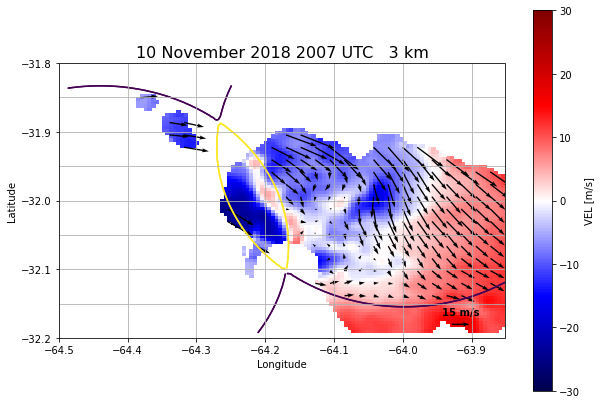

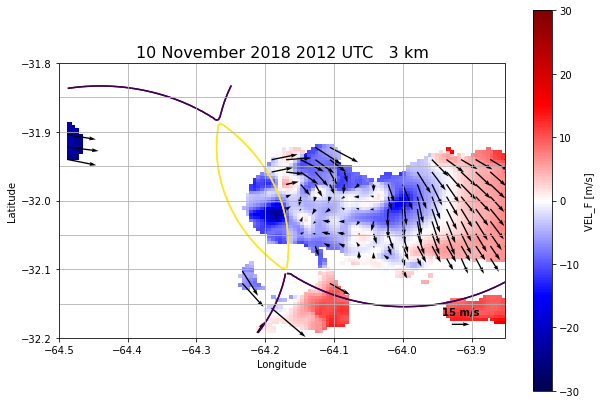

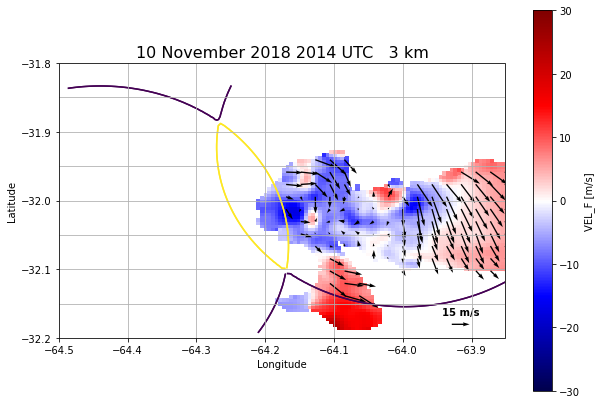

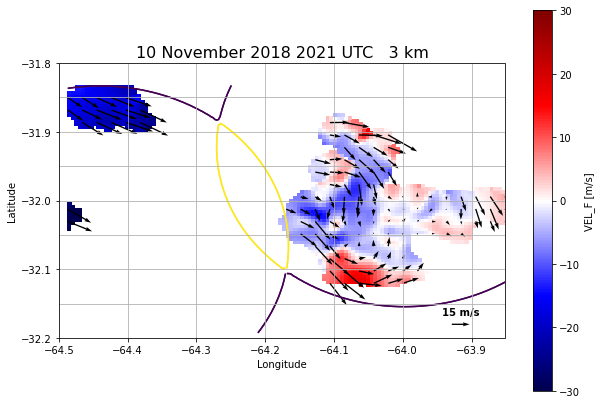

In [20]:
for time in times:
    new_grids = dual_doppler_analysis(time, smooth_param=0.5, use_sounding=True, second_param=0.001)

In [14]:
dow6_grid, dow7_grid = new_grids

In [15]:
dow7_dda = new_grids[1].to_xarray().squeeze()
dow6_dda = new_grids[0].to_xarray().squeeze()

dow7_dda = dow7_dda.where((dow7_dda.ZM > -10) & (dow6_dda.ZM > -10))

/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:652: RuntimeWarning: invalid value encountered in true_divide
  theta_1 = np.arccos(x/a)
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:653: RuntimeWarning: invalid value encountered in arccos
  theta_2 = np.arccos((x-rad2[1])/b)
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:654: RuntimeWarning: invalid value encountered in true_divide
  return np.arccos((a*a+b*b-c*c)/(2*a*b))
/Users/mgrover/miniconda3/envs/unidata/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: The following kwargs were not used by contour: 'color'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:653: RuntimeWarning: divide by zero encountered in true_divide
  theta_2 = np.arccos((x-rad2[1])/b)
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:653: RuntimeWarning: invalid value encountered in arccos
  theta_2

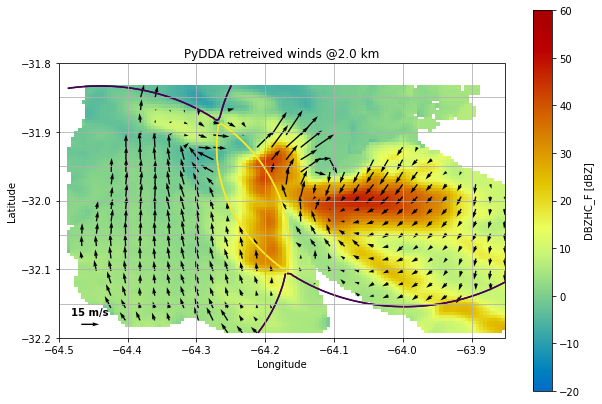

In [24]:
fig = plt.figure(figsize=(10,7))
ax = pydda.vis.plot_horiz_xsection_quiver_map(new_grids, background_field='ZM', level=3,
                                                  show_lobes=True, vmin=-20, vmax=60,
                                                  colorbar_contour_flag=True, contour_alpha=0.7,
                                                  quiverkey_len=15, quiver_spacing_x_km=2, quiver_spacing_y_km=2,
                                                  quiver_width=0.003, cmap='pyart_HomeyerRainbow')

plt.xlabel('Longitude')
plt.ylabel('Latitude')

#plt.title(f'{case} 2018 {time} UTC   3 km', fontsize=16)

#plt.savefig(f'plots/{case}/reflectivity_{time}_utc_3km.png', dpi=200)

plt.show()
plt.close()

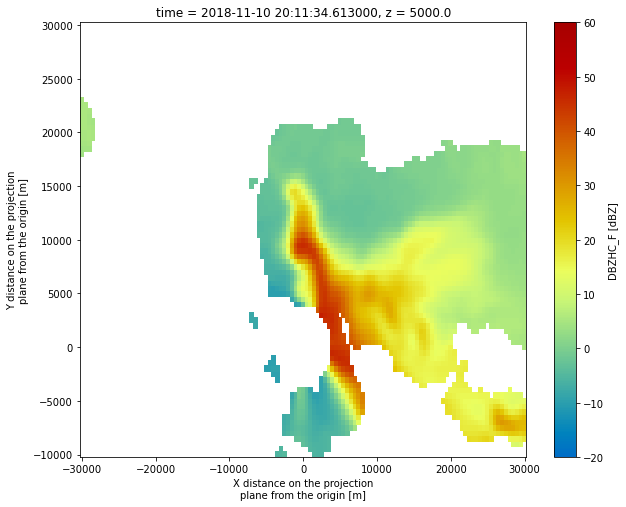

In [17]:
plt.figure(figsize=(10,8))
dow7_dda.sel(z=5000).ZM.plot(vmin=-20, vmax=60, cmap='pyart_HomeyerRainbow')

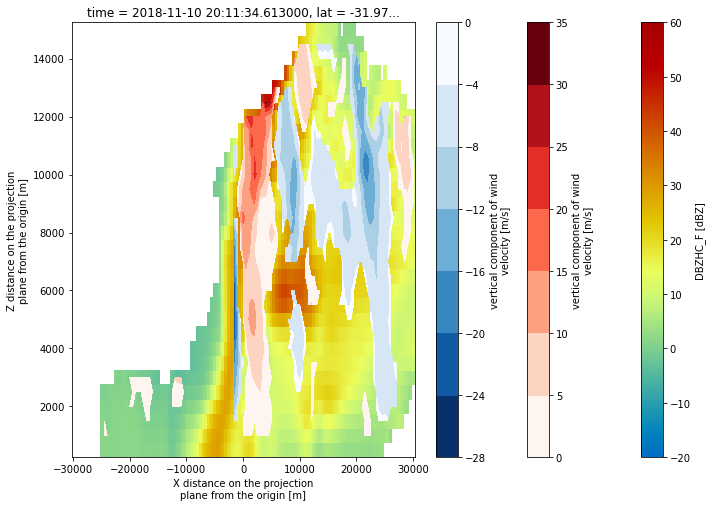

In [18]:
plt.figure(figsize=(12,8))
dow7_dda.sel(y=14000).ZM_composite.plot(vmin=-20, vmax=60, cmap='pyart_HomeyerRainbow')
dow7_dda.where(dow7_dda.w>1).sel(y=14000).w.plot.contourf(cmap='Reds')
dow7_dda.where(dow7_dda.w<-3).sel(y=14000).w.plot.contourf(cmap='Blues_r')

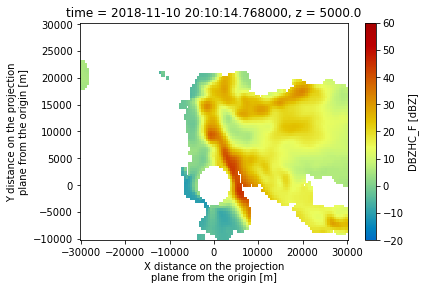

In [24]:
dow6_dda.sel(z=5000).ZM_composite.plot(vmin=-20, vmax=60, cmap='pyart_HomeyerRainbow')

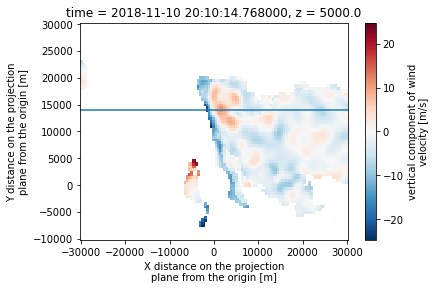

In [25]:
dow6_dda.sel(z=5000).w.plot()
plt.axhline(14000)

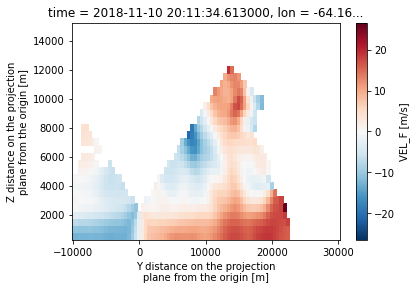

In [26]:
dow7_dda.sel(x=0).VM.plot()

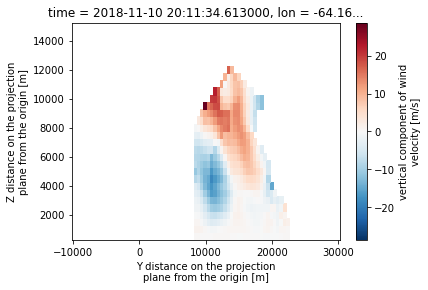

In [27]:
dow7_dda.sel(x=0).w.plot()

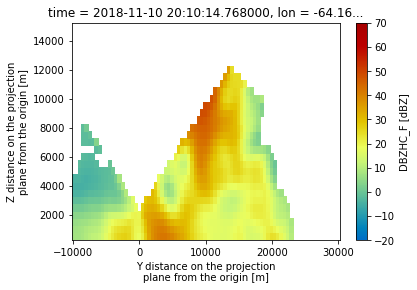

In [28]:
dow6_dda.sel(x=0).ZM_composite.plot(cmap='pyart_HomeyerRainbow', vmin=-20, vmax=70)

(0.0, 12000.0)

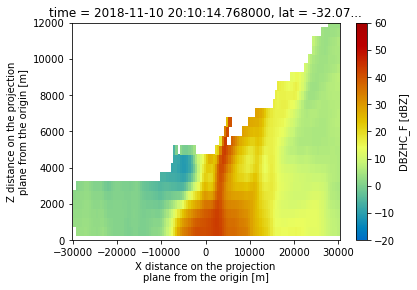

In [30]:
dow6_dda.sel(y=3000).ZM_composite.plot(vmin=-20, vmax=60, cmap='pyart_HomeyerRainbow')
plt.ylim(0,12000)

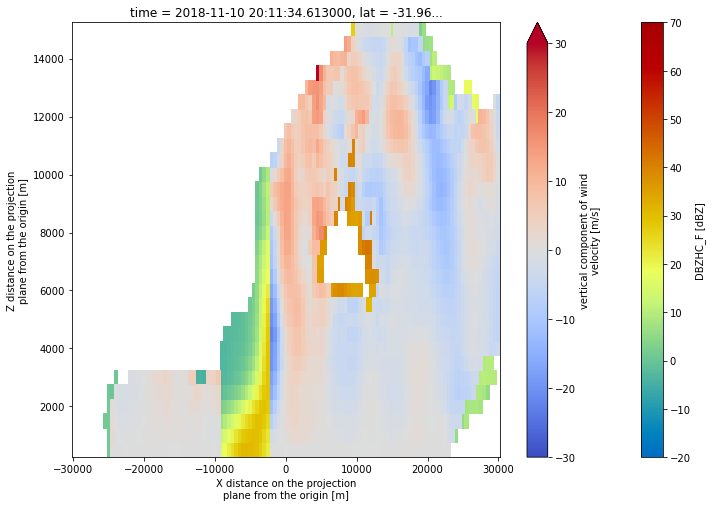

In [37]:
plt.figure(figsize=(12,8))
dow7_dda.sel(y=15000).ZM_composite.plot(vmin=-20, vmax=70, cmap='pyart_HomeyerRainbow')
dow7_dda.sel(y=15000).w.plot(cmap='coolwarm', vmin=-30, vmax=30)

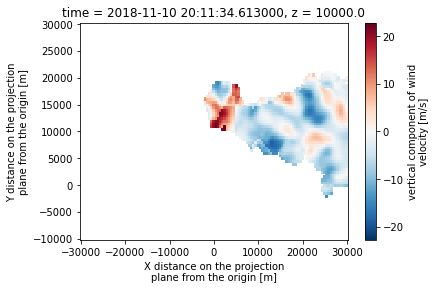

In [44]:
dow7_dda.sel(z=10000).w.plot()

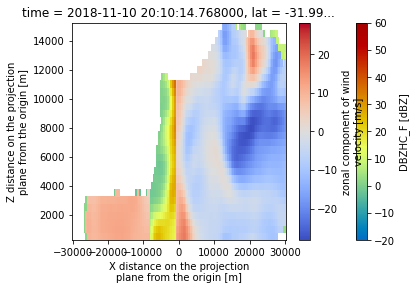

In [271]:
dow7_dda.sel(y=12000).ZM_composite.plot(vmin=-20, vmax=60, cmap='pyart_HomeyerRainbow')
dow6_dda.sel(y=12000).v.plot(cmap='coolwarm')

(0.0, 5000.0)

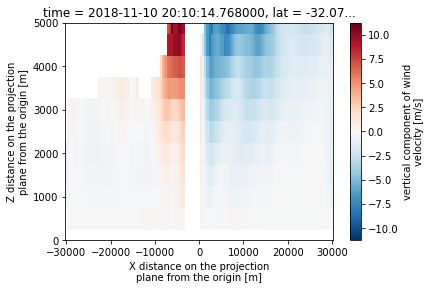

In [223]:
dow6_dda.sel(y=3000).w.plot()
plt.ylim(0,5000)

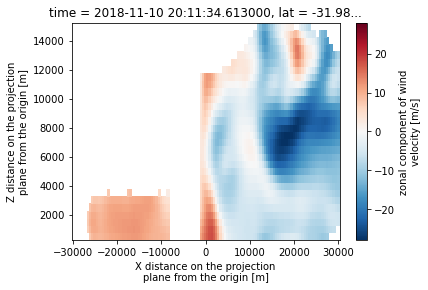

In [190]:
dow7_dda.sel(y=12500).v.plot()

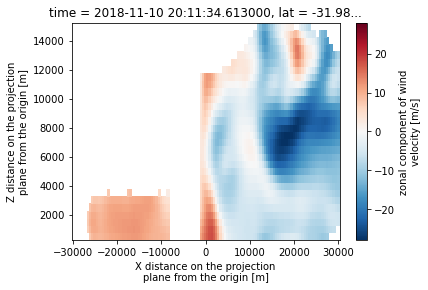

In [151]:
dow7_dda.sel(y=12500).v.plot()

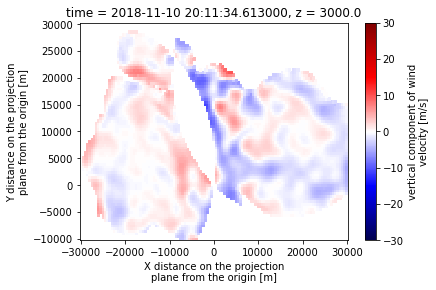

In [175]:
dow7_dda.sel(z=3000).w.plot(vmin=-30, vmax=30, cmap='seismic')

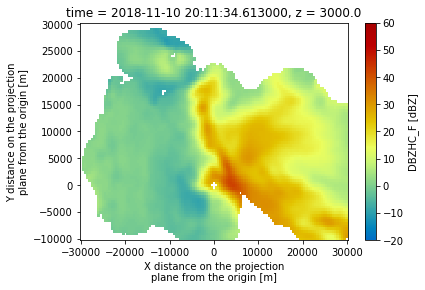

In [176]:
dow7_dda.sel(z=3000).ZM_composite.plot(vmin=-20, vmax=60, cmap='pyart_HomeyerRainbow')

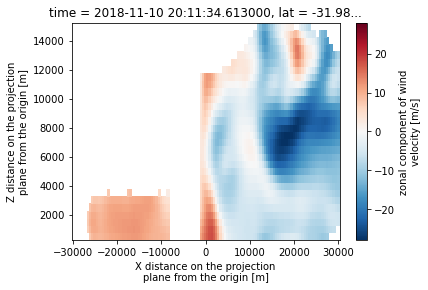

In [186]:
dow7_dda.sel(y=12500).v.plot()

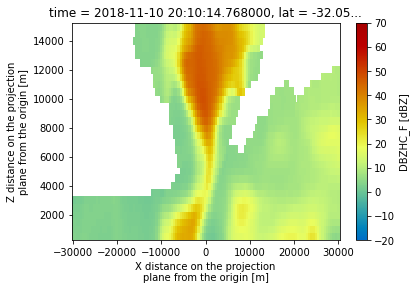

In [154]:
grid.sel(y=5000).ZM.plot(vmin=-20, vmax=70, cmap='pyart_HomeyerRainbow')

In [155]:
(profile.height[::-1] - new_grids[0].radar_altitude['data'][0])[3]

41.80000667572017

/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:652: RuntimeWarning: invalid value encountered in true_divide
  theta_1 = np.arccos(x/a)
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:653: RuntimeWarning: invalid value encountered in arccos
  theta_2 = np.arccos((x-rad2[1])/b)
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:654: RuntimeWarning: invalid value encountered in true_divide
  return np.arccos((a*a+b*b-c*c)/(2*a*b))
/Users/mgrover/miniconda3/envs/unidata/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: The following kwargs were not used by contour: 'color'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:653: RuntimeWarning: divide by zero encountered in true_divide
  theta_2 = np.arccos((x-rad2[1])/b)
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:653: RuntimeWarning: invalid value encountered in arccos
  theta_2

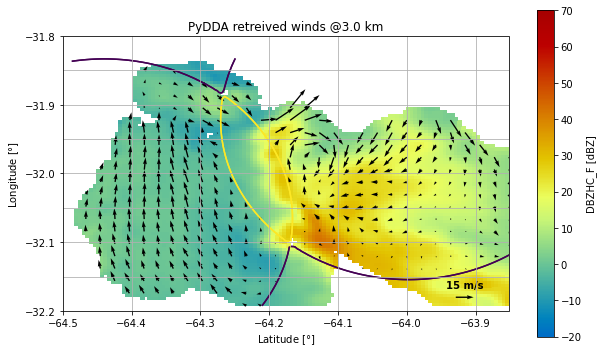

In [179]:
fig = plt.figure(figsize=(10,6))
pydda.vis.plot_horiz_xsection_quiver_map(new_grids, background_field='ZM_composite', level=5,
                                         show_lobes=True, bg_grid_no=1, vmin=-20, vmax=70,
                                         colorbar_contour_flag=True, contour_alpha=0.7,
                                         quiverkey_len=15, quiver_spacing_x_km=2, quiver_spacing_y_km=2,
                                         quiver_width=0.003, cmap='pyart_HomeyerRainbow')

In [157]:
new_grids[0].point_altitude['data'][0]

array([[500., 500., 500., ..., 500., 500., 500.],
       [500., 500., 500., ..., 500., 500., 500.],
       [500., 500., 500., ..., 500., 500., 500.],
       ...,
       [500., 500., 500., ..., 500., 500., 500.],
       [500., 500., 500., ..., 500., 500., 500.],
       [500., 500., 500., ..., 500., 500., 500.]])

/Users/mgrover/git_repos/PyDDA/pydda/vis/quiver_plot.py:213: UserWarning: linewidths is ignored by contourf
  alpha=contour_alpha)
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:652: RuntimeWarning: invalid value encountered in true_divide
  theta_1 = np.arccos(x/a)
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:653: RuntimeWarning: invalid value encountered in arccos
  theta_2 = np.arccos((x-rad2[1])/b)
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:654: RuntimeWarning: invalid value encountered in true_divide
  return np.arccos((a*a+b*b-c*c)/(2*a*b))
/Users/mgrover/git_repos/PyDDA/pydda/vis/quiver_plot.py:247: UserWarning: The following kwargs were not used by contour: 'color'
  levels=[bca_min, bca_max], color='k')
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:653: RuntimeWarning: divide by zero encountered in true_divide
  theta_2 = np.arccos((x-rad2[1])/b)
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retri

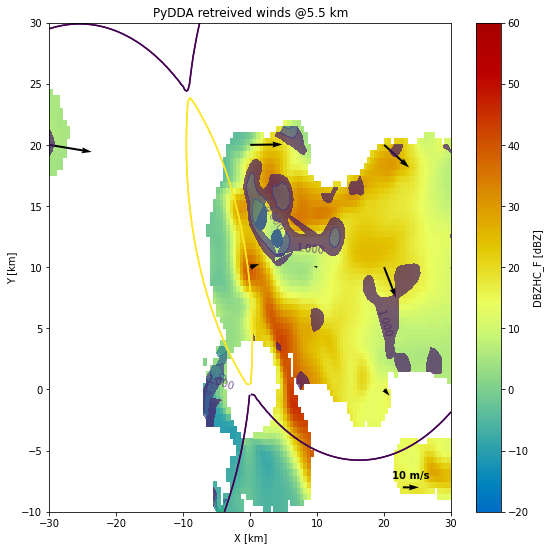

In [158]:
# Plot a vertical X-Z cross section
plt.figure(figsize=(9, 9))
pydda.vis.plot_horiz_xsection_quiver(new_grids, background_field='ZM_composite',
                                     level=10, w_vel_contours=np.arange(1, 26, 3),
                                  quiverkey_len=10,
                                  vmin=-20, vmax=60, quiver_width=0.005,
                                 cmap='pyart_HomeyerRainbow')
plt.show()

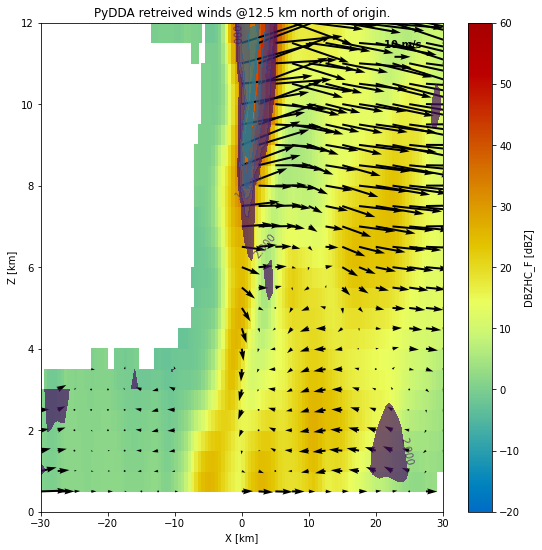

In [246]:
# Plot a vertical X-Z cross section
plt.figure(figsize=(9, 9))
pydda.vis.plot_xz_xsection_quiver(new_grids, background_field='ZM_composite',
                                 level=45,
                                 w_vel_contours=np.arange(2, 50, 4),
                                  quiver_spacing_x_km=2.5,
                                  quiver_spacing_z_km=.5,
                                  quiverkey_len=10,
                                  vmin=-20, vmax=60, quiver_width=0.005,
                                 cmap='pyart_HomeyerRainbow')

plt.ylim(0, 12)
plt.show()

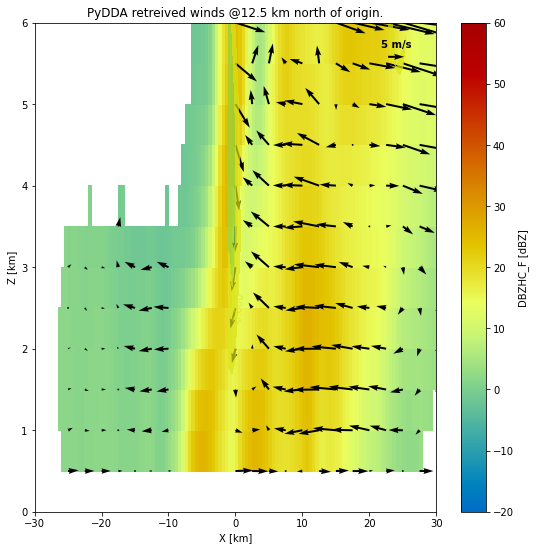

In [210]:
# Plot a vertical X-Z cross section
plt.figure(figsize=(9, 9))
pydda.vis.plot_xz_xsection_quiver(new_grids, background_field='ZM_composite',
                                 level=45,
                                 w_vel_contours=np.arange(-40, 0, 4),
                                  quiver_spacing_x_km=2.5,
                                  quiver_spacing_z_km=.5,
                                  quiverkey_len=5,
                                  vmin=-20, vmax=60, quiver_width=0.005,
                                 cmap='pyart_HomeyerRainbow')

plt.ylim(0, 6)
plt.show()

In [112]:
grid = new_grids[0].to_xarray().squeeze()

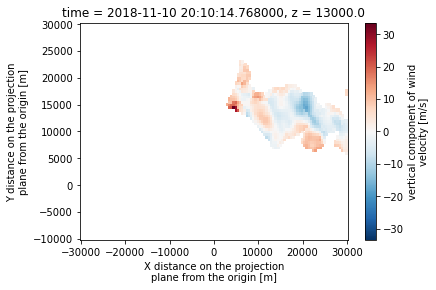

In [118]:
grid.sel(z=13000).w.plot()

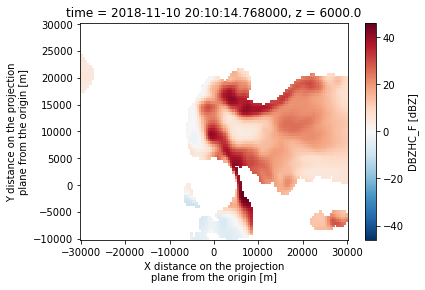

In [119]:
grid.sel(z=6000).ZM_composite.plot()

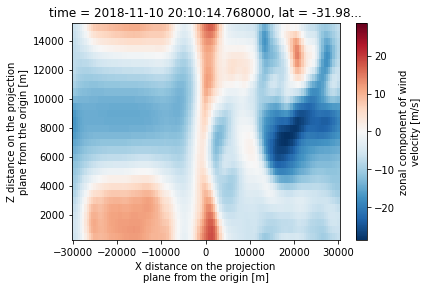

In [181]:
grid.sel(y=12500).v.plot()

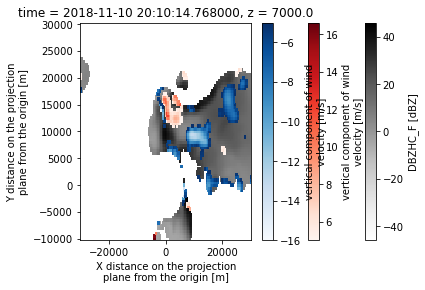

In [122]:
lev = 7000
grid.sel(z=lev).ZM_composite.plot(cmap='Greys')
grid.where(grid.w > 5).sel(z=lev).w.plot(cmap='Reds')
grid.where(grid.w < -5).sel(z=lev).w.plot(cmap='Blues')

In [15]:
for time in times:
    dual_doppler_analysis(time, smooth_param=0.5, use_sounding=True, second_param=0.01)

['ZM', 'VM', 'ROI', 'ZM_composite']
Interpolating sounding to radar grid
Interpolated U field:
[ 0.61185031 -1.47755905 -3.11542971  1.27490636  0.98365897  4.59610825
 11.56590905 13.22328765 14.42246695 16.88097903 16.26198126 15.486934
 24.26524903 29.94361949 33.6408602  33.91002067 33.26630542 34.42432932
 35.36828193 40.26716417 41.88335986 43.37174393 45.39279215 49.89085485
 51.89810168 51.09769665 40.63088394 38.73612332 36.24062356 37.56390412
 27.50475448]
Interpolated V field:
[ -5.26070678  -8.5         -7.74726563  -7.42471909  -1.2941386
   1.26006765  -0.84951296  -8.46149163  -9.87958884  -9.80951048
  -9.63306558  -8.92690818  -3.74969622  -8.04733177  -9.4311828
 -11.65330578 -14.23044334 -16.79278447 -14.92537446 -12.47014927
 -10.19522294  -9.81883738  -8.08481457  -7.78336648  -7.81769745
  -9.82140454   0.88509051  -4.98340675  -0.51205871   3.52406392
   4.50007798]
Grid levels:
[    0.   500.  1000.  1500.  2000.  2500.  3000.  3500.  4000.  4500.
  5000.  5500

/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:653: RuntimeWarning: divide by zero encountered in true_divide
  theta_2 = np.arccos((x-rad2[1])/b)
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:653: RuntimeWarning: invalid value encountered in arccos
  theta_2 = np.arccos((x-rad2[1])/b)
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:654: RuntimeWarning: invalid value encountered in true_divide
  return np.arccos((a*a+b*b-c*c)/(2*a*b))
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:408: RuntimeWarning: invalid value encountered in greater_equal
  bca[i, j] >= math.radians(min_bca),
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:409: RuntimeWarning: invalid value encountered in less_equal
  bca[i, j] <= math.radians(max_bca)))] += 1
/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py:419: RuntimeWarning: invalid value encountered in greater_equal
  bca[i, j] >= math.radians(min_bca),
/Users/m

| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
|31571.3042|  33.6316|20742.5778|  31.5501|   0.0000|   0.0000|   0.0000|   5.7617
Norm of gradient: 1.48853292906004
Iterations before filter: 10
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
|15573.0582| 262.7996|13843.3908|  70.1656|   0.0000|   0.0000|   0.0000|  16.9809
Norm of gradient: 0.47370527232067056
Iterations before filter: 20
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
|13592.2172| 330.3698|9118.7278|  78.0776|   0.0000|   0.0000|   0.0000|  19.5098
Norm of gradient: 0.20757479731910652
Iterations before filter: 30
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
|10190.7992| 487.4735|9157.6109|  97.2364|   0.0000|   0.0000|   0.0000|  24.4880
Norm of gradient: 0.43336046078081397
Iterations before filter: 40
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
|9575

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/mgrover/miniconda3/envs/unidata/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-4b869932aad0>", line 2, in <module>
    dual_doppler_analysis(time, smooth_param=0.5, use_sounding=True, second_param=0.01)
  File "<ipython-input-11-6cd94a096c02>", line 58, in dual_doppler_analysis
    mask_outside_opt=True)
  File "/Users/mgrover/git_repos/PyDDA/pydda/retrieval/wind_retrieve.py", line 518, in get_dd_wind_field
    fprime=grad_J, disp=0, iprint=-1)
  File "/Users/mgrover/miniconda3/envs/unidata/lib/python3.7/site-packages/scipy/optimize/lbfgsb.py", line 198, in fmin_l_bfgs_b
    **opts)
  File "/Users/mgrover/miniconda3/envs/unidata/lib/python3.7/site-packages/scipy/optimize/lbfgsb.py", line 360, in _minimize_lbfgsb
    f, g = func_and_grad(x)
  File "/Users/mgrover/miniconda3/envs/unidata/lib/python3.7/site-packages/scipy/

KeyboardInterrupt: 

In [34]:
def dual_doppler_analysis(time, smooth_param=0.02, use_sounding=True, second_param=1, case='Nov10', radar1='DOW6', radar2='DOW7'):
    """
    Runs dual doppler analysis using the specified times
    """
    
    # Read in the files
    dow6_files = glob.glob(f'output/{case}/{radar1}/v{time}/*')
    dow7_files = glob.glob(f'output/{case}/{radar2}/v{time}/*')
    
    # Read in the sounding
    #sounding = pyart.io.read_arm_sonde('soundings/corsondewnpnS1.b1.20181110.180000.custom.cdf')
    
    # Grid the radar data using the function above
    
    dow7_grid, dow6_grid = grid_radars(dow7_files[0], dow6_files[0])
    
    # Make sure only one value is used for each radar lat, lon, and altitude
    dow6_grid.radar_latitude['data'] = dow6_grid.radar_latitude['data'][0:1]
    dow6_grid.radar_longitude['data'] = dow6_grid.radar_longitude['data'][0:1]
    dow6_grid.radar_altitude['data'] = dow6_grid.radar_altitude['data'][0:1]

    dow7_grid.origin_altitude['data'] = dow7_grid.origin_altitude['data'][0:1]
    dow7_grid.origin_latitude['data'] = dow7_grid.origin_latitude['data'][0:1]
    dow7_grid.origin_longitude['data'] = dow7_grid.origin_longitude['data'][0:1]
    
    # Use ERA data to constrain the velocity field intialization
    dow6_grid = pydda.constraints.make_constraint_from_era_interim(dow6_grid, vel_field='VM')
    
    if use_sounding:
        
        # Load sounding data and insert as an intialization
        u_init, v_init, w_init = pydda.initialization.make_wind_field_from_profile(dow6_grid, sounding[1], vel_field='VM')
        
    else:
        # Otherwise use constant wind field
        u_init, v_init, w_init = pydda.initialization.make_constant_wind_field(dow6_grid, vel_field='VM')
    
    # Run the dual-doppler retrieval
    new_grids = pydda.retrieval.get_dd_wind_field([dow7_grid, dow6_grid],
                                                  u_init, v_init, w_init, vel_name='VM', refl_field='ZM',
                                                  Co=1., Cm=1000., Cx=second_param, Cy=second_param, upper_bc=True,
                                                  Cv=.001, Ut = 7.4, Vt = -13.34,
                                                  mask_outside_opt=True)
    
    # Write the first grid to netcdf containing the dual doppler analysis
    new_grids[1].to_xarray().reset_coords().to_netcdf(f'dual_output/{case}/vort_constraint_{time}_smooth_param_{smooth_param}.nc')

    ###################################
    # Plot 6 km Vertical Velocity (w)
    fig = plt.figure(figsize=(10,7))
    ax = pydda.vis.plot_horiz_xsection_quiver_map(new_grids, background_field='w', level=12,
                                                  show_lobes=True, bg_grid_no=1, vmin=-30, vmax=30,
                                                  colorbar_contour_flag=True, contour_alpha=0.7,
                                                  quiverkey_len=20, quiver_spacing_x_km=2, quiver_spacing_y_km=2, 
                                                  quiver_width=0.003, cmap='seismic')

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.title(f'{case} 2018 {time} UTC   6 km /n Smooth Param: {smooth_param}', fontsize=16)

    plt.savefig(f'plots/{case}/vort_constraint_vert_velocity_{time}_utc_6km_smooth_param_{smooth_param}.png', dpi=200)
    
    # Close out the figure
    plt.close()
    
    ##############################
    # Plot 3 km Vertical Velocity
    
    fig = plt.figure(figsize=(10,7))
    
    ax = pydda.vis.plot_horiz_xsection_quiver_map(new_grids, background_field='w', level=6,
                                                  show_lobes=True, bg_grid_no=1, vmin=-17, vmax=17,
                                                  colorbar_contour_flag=True, contour_alpha=0.7,
                                                  quiverkey_len=15, quiver_spacing_x_km=2, quiver_spacing_y_km=2,
                                                  quiver_width=0.003, cmap='seismic')

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.title(f'{case} 2018 {time} UTC   3 km /n Smooth Param: {smooth_param}', fontsize=16)

    plt.savefig(f'plots/{case}/vort_constraint_vert_velocity_{time}_utc_3km_smooth_param_{smooth_param}.png', dpi=200)
    
    plt.close()
    
    #############################
    # Plot 3 km Reflectivity

    fig = plt.figure(figsize=(10,7))
    ax = pydda.vis.plot_horiz_xsection_quiver_map(new_grids, background_field='ZM', level=6,
                                                  show_lobes=True, bg_grid_no=1, vmin=0, vmax=70,
                                                  colorbar_contour_flag=True, contour_alpha=0.7,
                                                  quiverkey_len=15, quiver_spacing_x_km=2, quiver_spacing_y_km=2,
                                                  quiver_width=0.003, cmap='pyart_HomeyerRainbow')

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.title(f'{case} 2018 {time} UTC   3 km /n Smooth Param: {smooth_param}', fontsize=16)

    plt.savefig(f'plots/{case}/vort_constraint_reflectivity_{time}_utc_3km_smooth_param_{smooth_param}.png', dpi=200)
    
    plt.close()
    
    #############################
    # Plot 3 km Radial Velocity
    fig = plt.figure(figsize=(10,7))
    ax = pydda.vis.plot_horiz_xsection_quiver_map(new_grids, background_field='VM', level=10,
                                                  show_lobes=True, bg_grid_no=1, vmin=-30, vmax=30,
                                                  colorbar_contour_flag=True, contour_alpha=0.7,
                                                  quiverkey_len=15, quiver_spacing_x_km=2, quiver_spacing_y_km=2,
                                                  quiver_width=0.003, cmap='seismic')

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.title(f'10 November 2018 {time} UTC   3 km /n Smooth Param: {smooth_param}', fontsize=16)

    plt.savefig(f'plots/vort_constraint_vel_{time}_utc_3km_smooth_param_{smooth_param}.png', dpi=200)

In [35]:
for time in times:
    dual_doppler_analysis(time, smooth_param=0.5, use_sounding=False, second_param=0)

Download ERA Interim data...
2020-08-31 13:28:43 ECMWF API python library 1.5.4
2020-08-31 13:28:43 ECMWF API at https://api.ecmwf.int/v1
2020-08-31 13:28:44 Welcome Maxwell Grover
2020-08-31 13:28:44 In case of problems, please check https://confluence.ecmwf.int/display/WEBAPI/Web+API+FAQ or contact servicedesk@ecmwf.int
2020-08-31 13:28:45 Request submitted
2020-08-31 13:28:45 Request id: 5f4d415d97446011ecb05c6c
2020-08-31 13:28:45 Request is submitted
2020-08-31 13:28:46 Request is active
Calling 'nice mars /tmp/20200831-1820/2d/tmp-_marscZUlTA.req'
mars - WARN -
mars - WARN - From 29 January 2019 10AM (UTC) MARS uses the interpolation
mars - WARN - provided by the MIR library. For more details, see
mars - WARN - https://confluence.ecmwf.int/display/UDOC/MARS+interpolation+with+MIR
mars - WARN -
MIR environment variables:
MIR_CACHE_PATH=/data/ec_coeff
mars - INFO   - 20200831.182846 - Welcome to MARS
mars - INFO   - 20200831.182846 - MARS Client bundle version: 6.28.6.1
mars - INFO

/Users/mgrover/miniconda3/envs/unidata/lib/python3.7/site-packages/pydda/retrieval/wind_retrieve.py:652: RuntimeWarning: invalid value encountered in true_divide
  theta_1 = np.arccos(x/a)
/Users/mgrover/miniconda3/envs/unidata/lib/python3.7/site-packages/pydda/retrieval/wind_retrieve.py:653: RuntimeWarning: invalid value encountered in arccos
  theta_2 = np.arccos((x-rad2[1])/b)
/Users/mgrover/miniconda3/envs/unidata/lib/python3.7/site-packages/pydda/retrieval/wind_retrieve.py:654: RuntimeWarning: invalid value encountered in true_divide
  return np.arccos((a*a+b*b-c*c)/(2*a*b))
/Users/mgrover/miniconda3/envs/unidata/lib/python3.7/site-packages/pydda/retrieval/wind_retrieve.py:408: RuntimeWarning: invalid value encountered in greater_equal
  bca[i, j] >= math.radians(min_bca),
/Users/mgrover/miniconda3/envs/unidata/lib/python3.7/site-packages/pydda/retrieval/wind_retrieve.py:409: RuntimeWarning: invalid value encountered in less_equal
  bca[i, j] <= math.radians(max_bca)))] += 1
/User

| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
| 146.6696| 637.9176|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  85.1680
Norm of gradient: 0.07935328058422833
Iterations before filter: 10
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
|  87.2911| 529.1742|   0.0000|   0.0000|   0.0001|   0.0000|   0.0000|  93.7495
Norm of gradient: 0.08120502082651836
Iterations before filter: 20
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
|  53.6721| 513.9433|   0.0000|   0.0000|   0.0001|   0.0000|   0.0000|  97.2404
Norm of gradient: 0.04814619965261029
Iterations before filter: 30
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
|  53.2962| 514.1742|   0.0000|   0.0000|   0.0001|   0.0000|   0.0000|  97.2578
Norm of gradient: 0.04830782412857658
Iterations before filter: 40
Applying low pass filter to wind field...
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvor

/Users/mgrover/miniconda3/envs/unidata/lib/python3.7/site-packages/pydda/retrieval/wind_retrieve.py:653: RuntimeWarning: divide by zero encountered in true_divide
  theta_2 = np.arccos((x-rad2[1])/b)
/Users/mgrover/miniconda3/envs/unidata/lib/python3.7/site-packages/pydda/retrieval/wind_retrieve.py:653: RuntimeWarning: invalid value encountered in arccos
  theta_2 = np.arccos((x-rad2[1])/b)
/Users/mgrover/miniconda3/envs/unidata/lib/python3.7/site-packages/pydda/retrieval/wind_retrieve.py:654: RuntimeWarning: invalid value encountered in true_divide
  return np.arccos((a*a+b*b-c*c)/(2*a*b))
/Users/mgrover/miniconda3/envs/unidata/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: The following kwargs were not used by contour: 'color'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/Users/mgrover/miniconda3/envs/unidata/lib/python3.7/site-packages/pydda/retrieval/wind_retrieve.py:652: RuntimeWarning: invalid value encountered in true_divide
  theta_1 = n

Download ERA Interim data...
2020-08-31 13:33:58 ECMWF API python library 1.5.4
2020-08-31 13:33:58 ECMWF API at https://api.ecmwf.int/v1
2020-08-31 13:33:58 Welcome Maxwell Grover
2020-08-31 13:33:59 In case of problems, please check https://confluence.ecmwf.int/display/WEBAPI/Web+API+FAQ or contact servicedesk@ecmwf.int
2020-08-31 13:33:59 Request submitted
2020-08-31 13:33:59 Request id: 5f4d4297cb8af4f322b05c74
2020-08-31 13:33:59 Request is submitted
2020-08-31 13:34:01 Request is active
Calling 'nice mars /tmp/20200831-1830/ef/tmp-_marsiWVvn_.req'
mars - WARN -
mars - WARN - From 29 January 2019 10AM (UTC) MARS uses the interpolation
mars - WARN - provided by the MIR library. For more details, see
mars - WARN - https://confluence.ecmwf.int/display/UDOC/MARS+interpolation+with+MIR
mars - WARN -
MIR environment variables:
MIR_CACHE_PATH=/data/ec_coeff
mars - INFO   - 20200831.183400 - Welcome to MARS
mars - INFO   - 20200831.183400 - MARS Client bundle version: 6.28.6.1
mars - INFO

/Users/mgrover/miniconda3/envs/unidata/lib/python3.7/site-packages/pydda/retrieval/wind_retrieve.py:652: RuntimeWarning: invalid value encountered in true_divide
  theta_1 = np.arccos(x/a)
/Users/mgrover/miniconda3/envs/unidata/lib/python3.7/site-packages/pydda/retrieval/wind_retrieve.py:653: RuntimeWarning: invalid value encountered in arccos
  theta_2 = np.arccos((x-rad2[1])/b)
/Users/mgrover/miniconda3/envs/unidata/lib/python3.7/site-packages/pydda/retrieval/wind_retrieve.py:654: RuntimeWarning: invalid value encountered in true_divide
  return np.arccos((a*a+b*b-c*c)/(2*a*b))
/Users/mgrover/miniconda3/envs/unidata/lib/python3.7/site-packages/pydda/retrieval/wind_retrieve.py:408: RuntimeWarning: invalid value encountered in greater_equal
  bca[i, j] >= math.radians(min_bca),
/Users/mgrover/miniconda3/envs/unidata/lib/python3.7/site-packages/pydda/retrieval/wind_retrieve.py:409: RuntimeWarning: invalid value encountered in less_equal
  bca[i, j] <= math.radians(max_bca)))] += 1
/User

| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
| 142.5886| 694.1900|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  80.6109
Norm of gradient: 0.3180886525353942
Iterations before filter: 10
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
|  91.8737| 578.0423|   0.0000|   0.0000|   0.0001|   0.0000|   0.0000|  92.4386
Norm of gradient: 0.2913748260632707
Iterations before filter: 20


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f83dd9d9dd0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
time = '2012'
dow6_files = glob.glob(f'output/DOW6/v{time}/*')
dow7_files = glob.glob(f'output/DOW7/v{time}/*')

In [ ]:
smoothing_vals = np.arange(0, .11, .01)

In [ ]:
for val in smoothing_vals:
    dual_doppler_analysis('2014', val, use_sounding=True)

---

## 12 November Case

In [7]:
import glob
dow6_files = sorted(glob.glob('output/Nov12/DOW6/*'))
dow7_files = sorted(glob.glob('output/Nov12/DOW7/*'))
dow8_files = sorted(glob.glob('output/Nov12/DOW8/*'))

In [8]:
dow6_files

['output/Nov12/DOW6/cfrad.20181112_020007.258_to_20181112_020420.238_DOW6high_SUR.nc',
 'output/Nov12/DOW6/cfrad.20181112_020431.790_to_20181112_020844.728_DOW6high_SUR.nc',
 'output/Nov12/DOW6/cfrad.20181112_021007.906_to_20181112_021420.886_DOW6high_SUR.nc',
 'output/Nov12/DOW6/cfrad.20181112_021432.438_to_20181112_021845.378_DOW6high_SUR.nc',
 'output/Nov12/DOW6/cfrad.20181112_022007.270_to_20181112_022420.250_DOW6high_SUR.nc',
 'output/Nov12/DOW6/cfrad.20181112_022431.802_to_20181112_022844.740_DOW6high_SUR.nc',
 'output/Nov12/DOW6/cfrad.20181112_023007.920_to_20181112_023420.900_DOW6high_SUR.nc',
 'output/Nov12/DOW6/cfrad.20181112_023432.450_to_20181112_023845.390_DOW6high_SUR.nc',
 'output/Nov12/DOW6/cfrad.20181112_024007.296_to_20181112_024420.276_DOW6high_SUR.nc',
 'output/Nov12/DOW6/cfrad.20181112_024431.826_to_20181112_024844.768_DOW6high_SUR.nc',
 'output/Nov12/DOW6/cfrad.20181112_025007.946_to_20181112_025420.926_DOW6high_SUR.nc',
 'output/Nov12/DOW6/cfrad.20181112_025432.4

In [ ]:
for i in range(len(dow6_files)):
    
    # Cleanup the radar data
    dow6_radar = cleanup_radar(dow6_files[i])
    dow7_radar = cleanup_radar(dow7_files[i])
    #dow8_radar = cleanup_radar(dow8_files[i])
    
    # Use DOW7 as the central lat and lon for regridding
    grid_lat = dow6_radar.latitude['data'][0]
    grid_lon = dow6_radar.longitude['data'][0]
    
    # Regrid the radars
    #gridded_radars = grid_radars([dow6_radar, dow7_radar, dow8_radar], grid_lat=grid_lat, grid_lon=grid_lon, vert_extent=14500,
    #                              horiz_extent=50000)
    
    gridded_radars = grid_radars([dow6_radar, dow7_radar], grid_lat=grid_lat, grid_lon=grid_lon, vert_extent=14500,
                                  horiz_extent=50000)
    
    # Run the dual doppler analysis
    run_dda(gridded_radars, case='Nov12')


In [ ]:
grid_lat = dow7_radar.latitude['data'][0]
grid_lon = dow7_radar.longitude['data'][0]

In [ ]:
gridded_radars = grid_radars([dow6_radar, dow7_radar, dow8_radar], grid_lat=grid_lat, grid_lon=grid_lon, vert_extent=14500,
                              horiz_extent=50000)

In [ ]:
run_dda(gridded_radars, case='Nov12')

In [ ]:
df = pd.read_csv('../ot_code/relampago_ots/20181112.02_1min.csv', index_col='time', parse_dates=True)

In [ ]:
df.head(10)

## 4 December Case

In [ ]:
import glob
dow6_files = glob.glob('output/Dec4/DOW6/*')
dow7_files = glob.glob('output/Dec4/DOW7/*')
dow8_files = glob.glob('output/Dec4/DOW8/*')

In [ ]:
dow6_radar = cleanup_radar(dow6_files[0])

In [ ]:
dow7_radar = cleanup_radar(dow7_files[0])

In [ ]:
dow8_radar = cleanup_radar(dow8_files[0])

In [ ]:
grid_lat = dow7_radar.latitude['data'][0]
grid_lon = dow7_radar.longitude['data'][0]

In [ ]:
gridded_radars = grid_radars([dow6_radar, dow7_radar, dow8_radar], grid_lat=grid_lat, grid_lon=grid_lon,
                              horiz_extent=50000)

In [ ]:
run_dda(gridded_radars, case='Dec4')